# Module Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

# Dataset

In [2]:
mnist_train = dset.MNIST("../data/MNIST", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
#mnist_test = dset.MNIST("../data/MNIST", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

Processing...
Done!


In [3]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
#test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

# Conditional VAE
![CVAE](complements/CVAE.png)

# Architecture

In [4]:
hidden_size = 10

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.fc1 = nn.Sequential(
                        nn.Conv2d(2,16,3,padding=1),   # batch x 16 x 28 x 28
                        nn.BatchNorm2d(16),
                        nn.ReLU(),
                        nn.MaxPool2d(2,2), 
                        nn.Conv2d(16,32,3,padding=1),  # batch x 32x 14 x 14
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(32,32,3,padding=1),  # batch x 32 x 7 x 7
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(32,64,3),            # batch x 64 x 1 x 1
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
        )
        self.fc2_1 = nn.Sequential(
                        nn.Linear(64*1*1, 256),
                        nn.ReLU(),
                        nn.Linear(256, hidden_size),
        )
        self.fc2_2 = nn.Sequential(
                        nn.Linear(64*1*1, 256),
                        nn.ReLU(),
                        nn.Linear(256, hidden_size),
        )
        self.relu = nn.ReLU()
                        
    def encode(self, x, label):
        
        c = label.view(-1,1,1,1).expand_as(x)
        out = self.fc1( torch.cat((x,c),1)) 
        out = out.view(x.size(0),-1)
        
        out = self.relu(out)
        mu = self.fc2_1(out)
        log_var = self.fc2_2(out)
        return mu,log_var
    
    def forward(self, x, label):

        mu, logvar = self.encode(x,label)
        noise = torch.randn(mu.size()).cuda()
        z = mu+logvar.exp()*noise    
        
        return z,mu,logvar
        
encoder = Encoder().cuda()

In [5]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.fc1 = nn.Sequential(
                        nn.Linear(hidden_size+1, 800),
                        nn.BatchNorm1d(800),
                        nn.ReLU(),
                        nn.Linear(800,1568),
                        nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
                        nn.ConvTranspose2d(32+1,16,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,8,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(8),
                        nn.ConvTranspose2d(8,1,3,1,1),
                        nn.BatchNorm2d(1),
        )
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    
    def forward(self, x, label):
       
        out = self.fc1(torch.cat((x,label.unsqueeze(1)),1))
        out = self.relu(out)
        out = out.view(x.size(0),32,7,7)
        
        c = label.view(-1,1,1,1).expand(x.size(0),1,7,7)
        out = self.fc2(torch.cat((out,c),1))
        out = self.sigmoid(out)
        out = out.view(x.size(0),1,28,28)
        
        return out
        
decoder = Decoder().cuda()

# Total Loss
![total_loss](complements/total_loss.JPG)
# Reconstruction Loss
![reconstruction_loss](complements/reconstruction_loss.JPG)
# KLD Loss
![KLD2](complements/KLD_analytic2.JPG)
![KLD](complements/KLD_analytic.JPG)


# Training

In [6]:
reconstruction_function = nn.BCELoss(size_average=False)

def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD

parameters = list(encoder.parameters())+ list(decoder.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.00001)

/home/isjeon/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
try:
    encoder, decoder = torch.load('./conditional_vae.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

num_epoch = 30

for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        image = image.cuda()
        label = label.cuda() 
        
        z, mu,log_var  = encoder(image, label.float())
        output = decoder(z, label.float())
        
        loss = loss_function(output, image, mu, log_var)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("loss is", loss.cpu().item())        



--------model not restored--------

loss is 51840.25390625
loss is 51024.19140625
loss is 50504.03515625
loss is 50188.29296875


In [ ]:
torch.save([encoder,decoder],'conditional_vae.pkl')

## Testing

torch.Size([100, 28, 28])


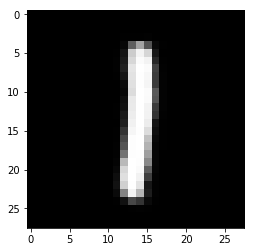

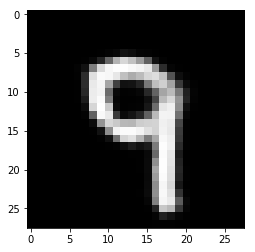

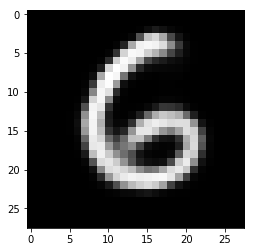

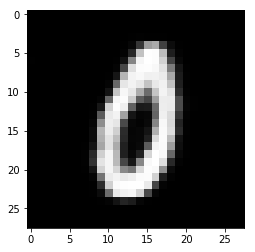

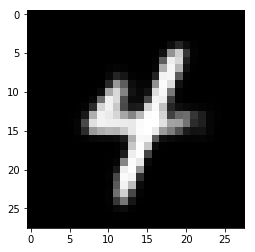

In [9]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    #plt.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
    #plt.show()
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

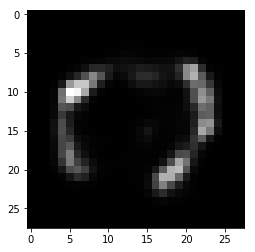

In [20]:
#image = image.cuda()
#z, mean, var = encoder(image)

decoder.eval()
z = torch.randn(1,hidden_size).cuda()
output = decoder(z,torch.FloatTensor([1]).cuda())
plt.imshow(output[0,0].cpu().detach().numpy(),cmap='gray')
plt.show()